# Resize operator

This notebook demonstrates the usage of Resize operator.

Resize operator resamples images, volumes* and sequences of images. It can be parameterized with respect to how the final output size is calculated and what kind of filtering or interpolation method is applied. It also supports resizing regions of interest (RoI).

> **Note** `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

> **Note** For detailed description of filtering methods, see "Interpolation methods" tutorial.

_\* You can see Resize applied to volumetric data in 3D transforms tutorial._

## Output Size Parameters

There are several ways to define how the image is resized.
The simplest way is to specify the desired output size explicitly. This can be done in two ways:
1. Use `size` argument, which can be a scalar (all extents equal), a list/tuple (sizes specified per-dimension) or a `DataNode` (a result of another DALI operator) - in which case it can be a list of tensors containing output sizes for respective samples.
2. Use separate arguments `resize_x`, `resize_y`, (`resize_z` is reserved for future use) - they can be either Python scalars or ``DataNode`` for per-sample sizes.

If an extent for any dimension is missing (0 or not specified), then it's selected to maintain the image aspect ratio.

In our first example, we'll use the default scaling mode (see section about scaling modes for details).

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali as dali
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import os.path
import PIL

test_data_root = os.environ["DALI_EXTRA_PATH"]
db_folder = os.path.join(test_data_root, "db", "lmdb")

In [2]:
batch_size = 8

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 100
    height = 100

    out = [
        images,
        # use tensor extent order - height, width
        dali.fn.resize(images, size=[height, width]),
        dali.fn.resize(images, resize_x=width, resize_y=height),
        dali.fn.resize(images, resize_x=width),
        dali.fn.resize(images, size=[0, width]),
        dali.fn.resize(images, resize_y=height),
        dali.fn.resize(images, size=[height, 0]),
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

Let's define utilities for diplaying the outputs

In [3]:
def show_images(images, labels, size, columns=2):
    from synsets import imagenet_synsets
    import matplotlib.gridspec as gridspec

    num_img = len(images)
    fig = plt.figure(figsize=size)
    plt.suptitle(None)
    rows = int(math.ceil(num_img / columns))
    gs = gridspec.GridSpec(rows, columns)
    for i in range(num_img):
        plt.subplot(gs[i])
        plt.axis("off")
        plt.title(labels[i] if labels is not None else "")
        img_chw = images[i]
        plt.imshow((img_chw) / 255.0)


def show_outputs(pipe_out, idx, labels, size, columns=2):
    len_outputs = len(pipe_out)
    images = [
        out.as_cpu().at(idx) if hasattr(out, "as_cpu") else out.at(idx)
        for out in pipe_out
    ]
    show_images(images, labels, size, columns)


def show_batch(tlist, labels, size, columns=2):
    images = [
        tlist.as_cpu().at(idx) if hasattr(tlist, "as_cpu") else tlist.at(idx)
        for idx in range(len(tlist))
    ]
    show_images(images, labels, size, columns)

Original image


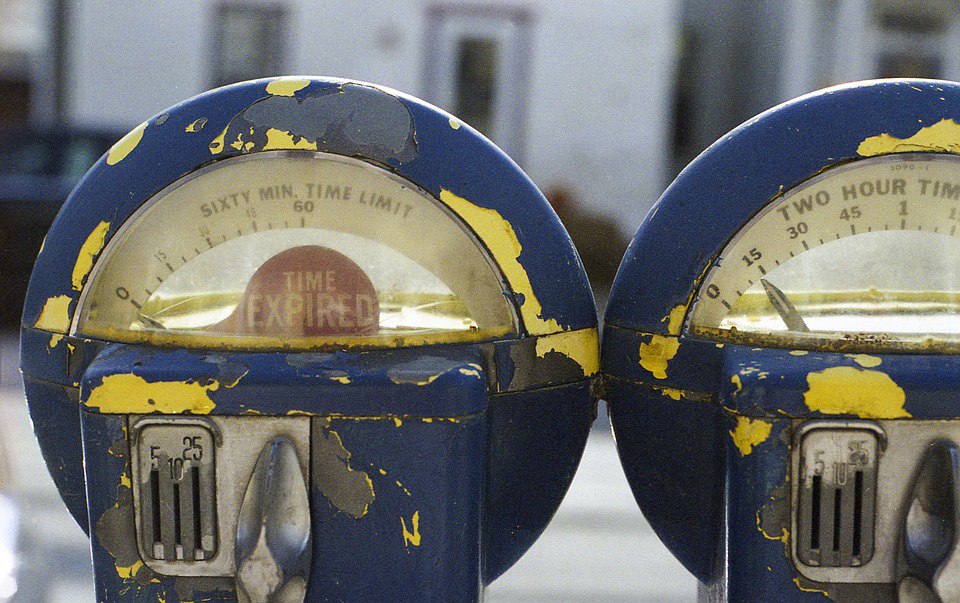

In [4]:
print("Original image")
idx = 5  # adjust to see other images
PIL.Image.fromarray(pipe_out[0].as_cpu().at(idx))

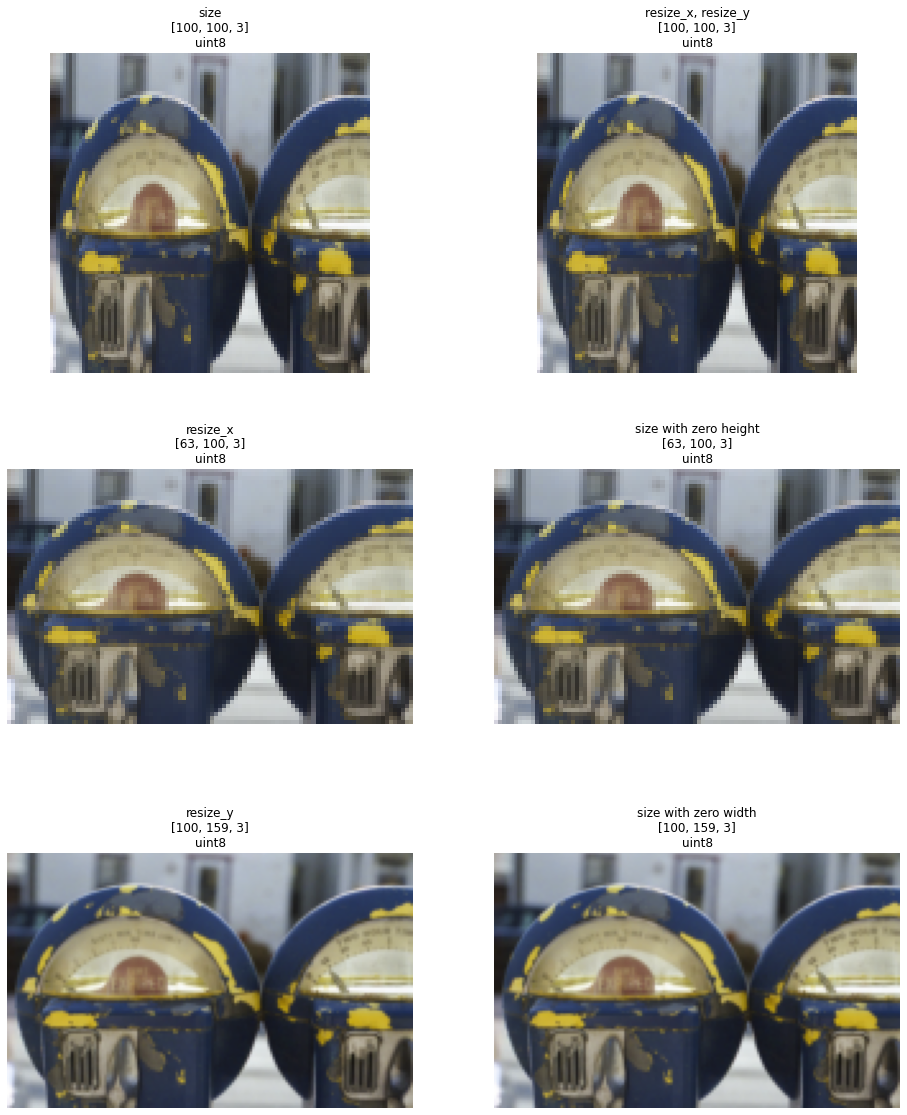

In [5]:
labels = [
    "size",
    "resize_x, resize_y",
    "resize_x",
    "size with zero height",
    "resize_y",
    "size with zero width",
]
for i in range(len(pipe_out) - 1):
    labels[i] += "\n{}".format(pipe_out[i + 1].at(idx).shape())
    cpu_out = pipe_out[i + 1].as_cpu()
    labels[i] += "\n{}".format(cpu_out.at(idx).dtype)
show_outputs(pipe_out[1:], idx, labels, (16, 20))

## Scaling Modes

Resize supports four resize modes:

**"default"** - the dimensions which are specified, are scaled to the requested size; the missing extents are calculated by applying average scale of the provided extents - for 2D and one extent specified, this means that aspect ratio is preserved

**"stretch"** - the dimensions which are specified, are scaled to the requested size; the missing ones are not scaled at all

**"not_larger"** - the image is scaled so that no dimension exceeds the specified size; aspect ratio is preserved

**"not_smaller"** - the image is scaled so that no dimension is smaler than specified (additionally, ``max_size`` argument may be used to limit upscaling of inputs with very high aspect ratios)

> ### Legacy Scaling Modes
> * ``resize_shorter`` and ``resize_longer`` work as if the same size was specified for all axes and the mode to "not_smaller" and "not_larger", respectively


In [6]:
batch_size = 8

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 200
    height = 100

    out = [
        dali.fn.resize(images, size=[height, width]),
        dali.fn.resize(images, resize_x=width),
        dali.fn.resize(images, resize_y=height),
        dali.fn.resize(images, size=[height, width], mode="stretch"),
        dali.fn.resize(images, resize_x=width, mode="stretch"),
        dali.fn.resize(images, resize_y=height, mode="stretch"),
        dali.fn.resize(images, size=[height, width], mode="not_larger"),
        dali.fn.resize(images, size=[height, width], mode="not_smaller"),
        dali.fn.resize(
            images,
            size=[height, width],
            mode="not_smaller",
            max_size=[110, 200],
        ),
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

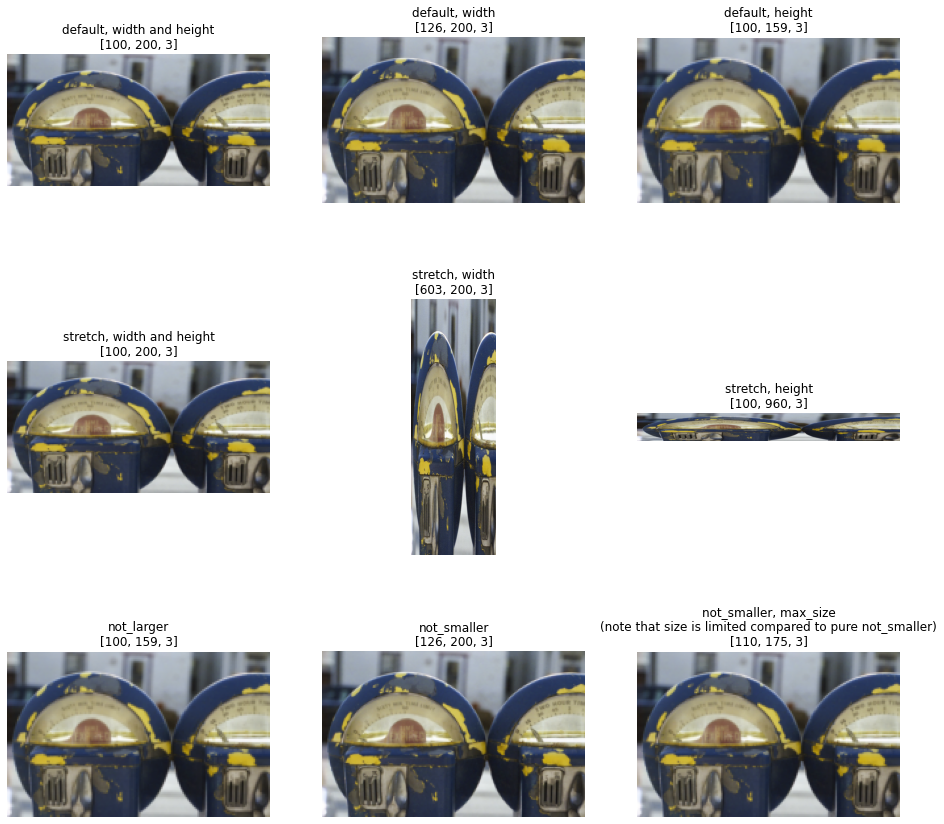

In [7]:
labels = [
    "default, width and height",
    "default, width",
    "default, height",
    "stretch, width and height",
    "stretch, width",
    "stretch, height",
    "not_larger",
    "not_smaller",
    "not_smaller, max_size\n(note that size is limited compared to pure "
    "not_smaller)",
]
for i in range(len(pipe_out)):
    labels[i] += "\n{}".format(pipe_out[i].at(idx).shape())
show_outputs(pipe_out, idx, labels, size=(16, 16), columns=3)

## Region of Interest (RoI) Processing

If only a part of the input image should be scaled, it can be specified using ``roi_start`` and ``roi_end`` parameters. RoI can be specified either in absolute (pixel) coordinates or in relative ones (0..1) if ``roi_relative=True`` is specified.


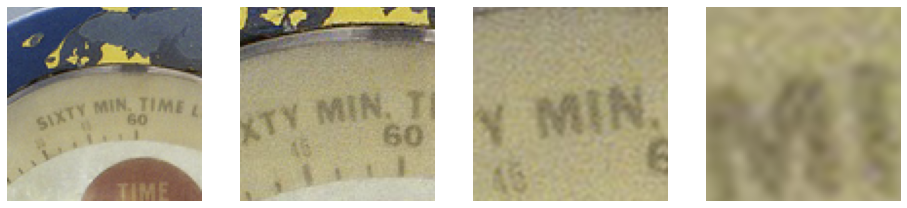

In [8]:
batch_size = 8

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    cx = 270
    cy = 190
    out = [
        dali.fn.resize(
            images,
            interp_type=dali.types.INTERP_LANCZOS3,
            size=[100, 100],
            roi_start=[cy - r, cx - r],
            roi_end=[cy + r, cx + r],
        )
        for r in [100, 50, 30, 10]
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = [""] * 4
show_outputs(pipe_out, idx, labels, size=(16, 4), columns=4)

#### Flipping with RoI
If ``roi_end[d] > roi_start[d]`` the image is flipped in dimensions _d_.

#### Out-of-bounds and Degenerate Coordinates
Out of bounds input coordinates are clamped, resuting in repeating the border pixels.

If the RoI is degenerate (has zero extent), resize will broadcast the source image sampled at the RoI coordinate along the degenerate axis.

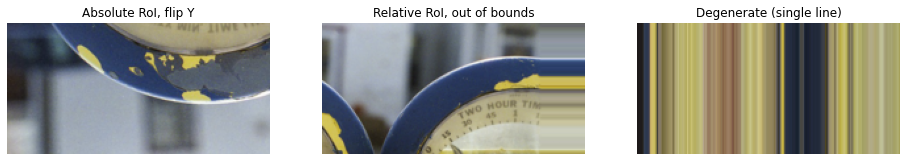

In [9]:
pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 200
    height = 100

    out = [
        dali.fn.resize(
            images, size=[height, width], roi_start=[200, 0], roi_end=[0, 400]
        ),
        dali.fn.resize(
            images,
            size=[height, width],
            roi_start=[0, 0.5],
            roi_end=[0.5, 1.1],
            roi_relative=True,
        ),
        dali.fn.resize(
            images,
            size=[height, width],
            roi_start=[0.5, 0],
            roi_end=[0.5, 1],
            roi_relative=True,
        ),
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = [
    "Absolute RoI, flip Y",
    "Relative RoI, out of bounds",
    "Degenerate (single line)",
]
show_outputs(pipe_out, idx, labels, size=(16, 8), columns=3)

## Fused Flip

Resize can flip the image in one of two ways:
 1. specify RoI with ``roi_start > roi_end``
 2. specify negative output size
 
If 1 and 2 coincide, flipping is cancelled.

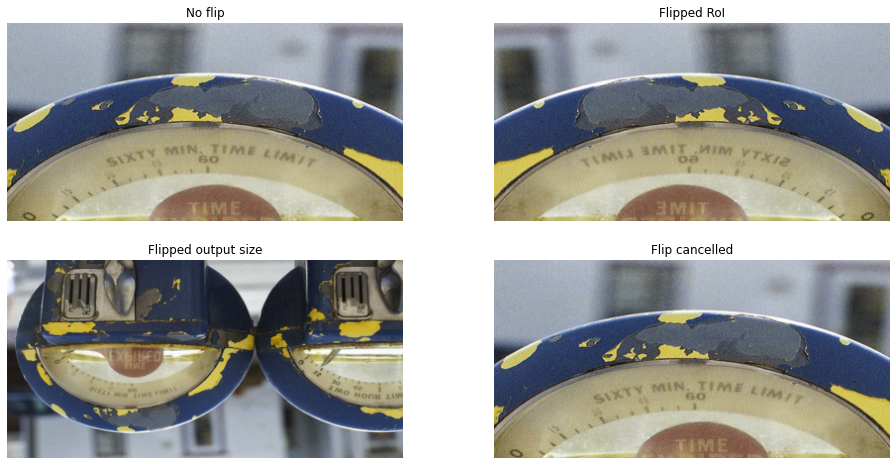

In [10]:
pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 400
    height = 200

    out = [
        # Just resize the RoI, no flipping
        dali.fn.resize(
            images, size=[height, width], roi_start=[0, 100], roi_end=[300, 500]
        ),
        # Flip the RoI
        dali.fn.resize(
            images, size=[height, width], roi_start=[0, 500], roi_end=[300, 100]
        ),
        # Negative size also results in a flip
        dali.fn.resize(images, size=[-height, width]),
        # Flip cancelled by both negative size and flipped RoI
        dali.fn.resize(
            images,
            size=[height, -width],
            roi_start=[0, 500],
            roi_end=[300, 100],
        ),
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = ["No flip", "Flipped RoI", "Flipped output size", "Flip cancelled"]
show_outputs(pipe_out, idx, labels, size=(16, 8), columns=2)

## Input and Output Types

Resize can handle inputs of the following type:
- uint8
- int16
- uint16
- float
The output can be in float, regardless of input type. 

The example below demonstrates how Resize handles negative values for INT16 and extended dynamic range for float.

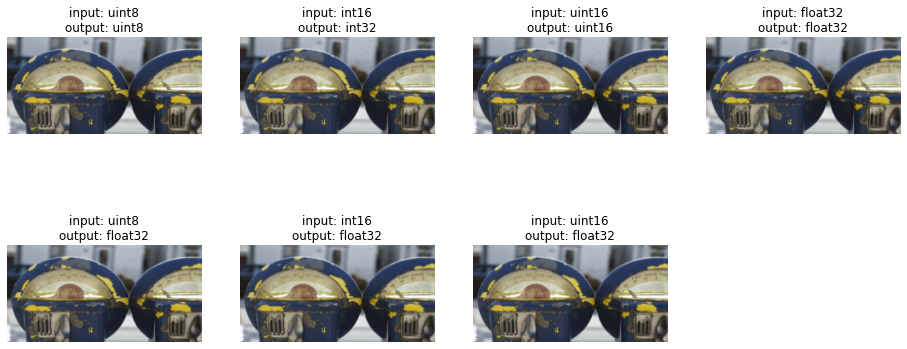

In [11]:
batch_size = 8

pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    files, labels = dali.fn.readers.caffe(
        path=db_folder, random_shuffle=True, seed=1234
    )
    images = dali.fn.decoders.image(files, device="mixed")

    width = 200
    height = 100

    # make some pixels negative
    images_i16 = dali.fn.cast(images - 128, dtype=dali.types.INT16)
    images_u16 = dali.fn.cast(images, dtype=dali.types.UINT16)
    images_f32 = (
        images / 256.0
    )  # scale to 0..1 range, to demonstrate resizing with fractional intensities

    out = [
        dali.fn.resize(images, size=[height, width]),
        dali.fn.resize(images_i16, size=[height, width])
        + 128,  # back to positive values
        dali.fn.resize(images_u16, size=[height, width]),
        dali.fn.resize(images_f32, size=[height, width])
        * 256,  # scale back to 0..255 range for display
        dali.fn.resize(images, size=[height, width], dtype=dali.types.FLOAT),
        dali.fn.resize(images_i16, size=[height, width], dtype=dali.types.FLOAT)
        + 128,
        dali.fn.resize(
            images_u16, size=[height, width], dtype=dali.types.FLOAT
        ),
    ]

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = [
    "input: uint8",
    "input: int16",
    "input: uint16",
    "input: float32",
    "input: uint8",
    "input: int16",
    "input: uint16",
]
for i in range(len(pipe_out)):
    out_cpu = pipe_out[i].as_cpu()
    labels[i] += "\noutput: {}".format(out_cpu.at(idx).dtype)
show_outputs(pipe_out, idx, labels, size=(16, 7), columns=4)

## Internal Conversion to `float`

When converting to `float`, the interpolation may result in fractional values, not representable in the input type. The example below demonstrates scaling a checkerboard with bilinear interpolation. With integer output, quantization artifacts are clearly visible.

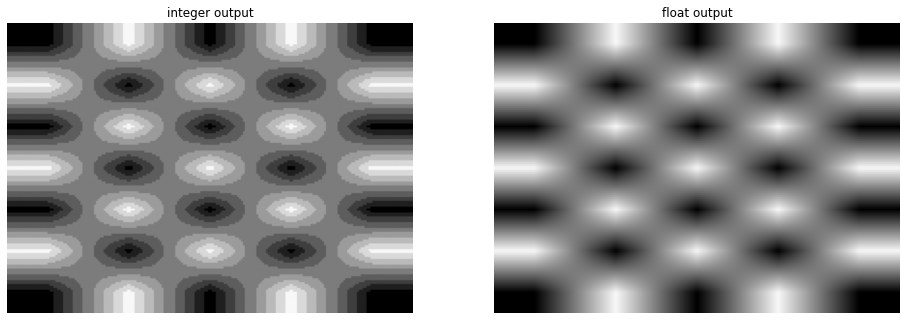

In [12]:
batch_size = 1

checkerboard = (
    (
        np.array([[1, 0, 1, 0, 1]])
        ^ np.array([[1], [0], [1], [0], [1], [0], [1]])
    )
)[:, :, np.newaxis]
checkerboard = (checkerboard * np.array([[[8, 8, 8]]])).astype(np.uint8)


def get_batch():
    return [checkerboard] * batch_size


pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    images = dali.fn.external_source(get_batch, dtype=dali.types.UINT8)

    out = [
        dali.fn.resize(images, size=[150, 210]) * 31,
        dali.fn.resize(images, size=[150, 210], dtype=dali.types.FLOAT) * 31,
    ]
    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = ["integer output", "float output"]
show_outputs(pipe_out, 0, labels, size=(16, 6), columns=2)

## Subpixel Scale

If the output size is not integer - either because it was specified this way, or as an attempt to maintain aspect ratio - there are two ways to deal with the situation.
By default, subpixel scaling is used - i.e. the output canvas size of course needs to be integer, but the input RoI is adjusted to maintain original scaling factor.
This can be disabled, by setting ``subpixel_scale`` to ``False``, which adjust the scaling factor to the rounded size.
This may be important for applications for which maintaining the aspect ratio is critical at subpixel level.
The example below illustrates this subtel difference by scaling a small checkerboard pattern.

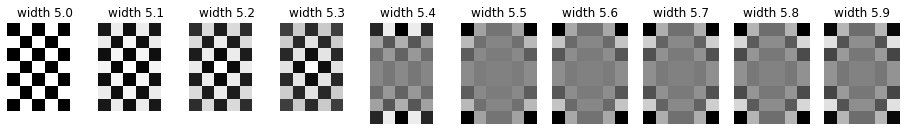

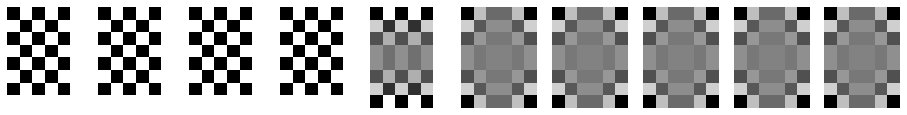

In [13]:
batch_size = 10

checkerboard = (
    (
        np.array([[1, 0, 1, 0, 1]])
        ^ np.array([[1], [0], [1], [0], [1], [0], [1]])
    )
    * 255
).astype(np.uint8)[:, :, np.newaxis]
checkerboard = checkerboard * np.array([[[1, 1, 1]]], dtype=np.uint8)


def get_batch():
    return [checkerboard] * batch_size


def get_widths():
    return (np.arange(batch_size) * 0.1 + checkerboard.shape[1]).astype(
        np.float32
    )


pipe = dali.pipeline.Pipeline(batch_size, 3, 0)
with pipe:
    images = dali.fn.external_source(get_batch, dtype=dali.types.UINT8)
    widths = dali.fn.external_source(get_widths, dtype=dali.types.FLOAT)

    out = [
        dali.fn.resize(images, resize_x=widths),
        dali.fn.resize(images, resize_x=widths, subpixel_scale=False),
    ]
    # pad the batch to uniform size, to avoid confusing additional scaling
    # by jupyter
    out = dali.fn.pad(out, fill_value=255)

    pipe.set_outputs(*out)

pipe.build()
pipe_out = pipe.run()

labels = ["width {:.1f}".format(w) for w in get_widths()]
show_batch(pipe_out[0], labels, size=(16, 10), columns=10)
show_batch(pipe_out[1], None, size=(16, 10), columns=10)

As we see, images in the top row, with subpixel scaling enabled, are changing gradually.
In the bottom row, there are hard transitions between subsequent, quantized, output sizes.